In [1]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from xgboost_order import process_kline, inference
from helper import get_binance_ohlc_time, generate_date_list, calculate_rsi_with_ema, is_decrease, is_pin_bar


In [2]:



def rule(df_btc, df, tp=1, sl=5, money=1000, model = None, num_random=10000, window_test=10, seq=30, time_pred=10, manual_cond=False):
    dfcopy = df.copy()
    number_high = 0
    number_low = 0
    cannot_break = 0
    results = []
    list_reward = []
    balance = 0
    price_line = []

    index_condition = []
    if model is None:
        index_condition = np.random.randint(100, len(df), num_random)
    else:
        for i in range(seq+1, len(df)-1, window_test):
            x_array = df.loc[i-seq:i-1, ["open", "high", "low", "close", "volumn"]].to_numpy()
            x_array_cp = x_array.copy()
            rsi_6 = calculate_rsi_with_ema(x_array, 6)
            y_pred_prob = inference(x_array, model)
            if y_pred_prob == 1:
                if manual_cond:
                    if is_decrease(x_array_cp[-1]) or is_decrease(x_array_cp[-2]) or is_pin_bar(x_array_cp[-1]): 
                        if rsi_6[-1] > 20 and rsi_6[-2] > 20:
                            index_condition.append(i)
                else:
                    index_condition.append(i)
    index_condition = sorted(index_condition)
    for i in index_condition:
        a = df['open'].iloc[i]
        high_check = False
        low_check = False
        if time_pred == "all":
            end = len(df)
        else:
            end = i+time_pred
        for j in range(i,end):
            if j >= len(df):
                break
            high_check = df['high'].iloc[j] >= (1+sl*0.01) * a
            low_check = df['low'].iloc[j] <= (1-tp*0.01) * a
            if high_check and low_check:
                print("check lai")
                break
            if high_check:
                balance += -money*sl/100
                list_reward.append(balance)
                price_line.append(j)
                number_high+=1
                results.append((i, df.iloc[i]['timestamp'], df.iloc[j]['timestamp'], "high"))
                break
            if low_check:
                price_line.append(j)
                balance += money*tp/100
                list_reward.append(balance)
                number_low+=1
                # print(df.iloc[i])
                # print("low", j-i)
                results.append((i, df.iloc[i]['timestamp'], df.iloc[j]['timestamp'], "low"))
                break
        if not high_check and not low_check and j<len(df):
            if df.iloc[j]['close'] < a:
                # print("win: ", df.iloc[j]['close'], df.iloc[i]['open'], money * (1 - df.iloc[j]['close'] / df.iloc[i]['open']))
                pnl = money * (1 - df.iloc[j]['close'] / df.iloc[i]['open'])
                balance += pnl
            else:
                # print("lose: ", df.iloc[j]['close'], df.iloc[i]['open'], -money * (df.iloc[j]['close'] / df.iloc[i]['open']-1))
                pnl = -money * (df.iloc[j]['close'] / df.iloc[i]['open']-1)
                balance += pnl
            list_reward.append(balance)
            price_line.append(j)
            results.append((i, df.iloc[i]['timestamp'], df.iloc[j]['timestamp'], "not", round(pnl, 2)))
            cannot_break += 1
    prices_list = df.loc[price_line, 'open'].tolist()

    print("num points: ", len(index_condition), "number_low/all_point", round(number_low/(number_low+number_high+0.01), 3), "cannot_break", cannot_break)

    return results, index_condition, number_high, number_low, list_reward, prices_list

In [3]:
# start = "2024-05-15"
# end = "2024-09-29"
# list_day = generate_date_list(start, end, 4)
# list_day.append(end)
# df_all = []
# symb = "ORDIUSDT"
# interval = "15m"
# for i in range(len(list_day)-1):
#     df = get_binance_ohlc_time(symb, interval, list_day[i]+" 00:15:00", list_day[i+1]+" 00:00:00")
#     df_all.append(df)
# df_all = pd.concat(df_all,ignore_index=True, axis=0)
# csv_file = f"data_his/{symb}_{start}_{end}_{interval}.csv"
# df_all.to_csv(csv_file, index=False)
# df_all = pd.read_csv(csv_file)
df_all = pd.read_csv("data_his/ORDIUSDT_2024-05-15_2024-09-29_15m.csv")

In [4]:
df_all

,timestamp,open,high,low,close,volumn
0,2024-05-15 00:15:00,35.66,36.02,35.65,35.76,7250.05
1,2024-05-15 00:30:00,35.76,35.76,35.42,35.61,12639.87
2,2024-05-15 00:45:00,35.61,35.74,35.53,35.63,4389.21
3,2024-05-15 01:00:00,35.63,35.88,35.55,35.87,3728.77
4,2024-05-15 01:15:00,35.86,36.15,35.84,36.04,17473.50
...,...,...,...,...,...,...
13147,2024-09-28 23:00:00,39.94,40.05,39.90,39.95,3523.49
13148,2024-09-28 23:15:00,39.95,39.95,39.64,39.83,4443.30
13149,2024-09-28 23:30:00,39.84,39.90,39.49,39.62,15518.03
13150,2024-09-28 23:45:00,39.63,39.76,39.59,39.66,4090.78


In [ ]:
df = df_all.iloc[:35000].reset_index(drop=True)#.drop(columns=['fluct', 'amp'])
display(df.head(1))
display(df.tail(2))
rs, idcond, high_check, low_check, list_reward, prices_list = rule(df, df, tp=1.5, sl=1.5, num_random=20000)


In [ ]:
def create_dataset(df, rs, sequence_length):
    x = []
    y = []
    for point in rs:
        index = point[0]
        
        x_array = df_all.iloc[index-sequence_length:index].values[:,1:].astype(np.float32)
        
        min_vol = np.min(x_array[:,-1])
        max_vol = np.max(x_array[:,-1])
        if min_vol == 0:
            continue

        # x_array[:,-1] = (x_array[:,-1]-min_vol)/(max_vol-min_vol)
        x_array[:,-1] = x_array[:,-1]/min_vol

        min_price = np.min(x_array[:,:4])
        max_price = np.max(x_array[:,:4])
        x_array[:,:4] = (x_array[:,:4] - min_price) / (max_price - min_price)
        x.append(x_array)

        if point[-1] == "low":
            y.append(1)
        elif point[-1] == "high":
            y.append(2)
        else:
            y.append(0)
    return x, y

x, y = create_dataset(df_all, rs, 30)
x = np.array(x)
y = np.array(y)
x = x.reshape(x.shape[0], -1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)


param = {
    'max_depth': 25,
    'eta': 0.1,
    'objective': 'multi:softmax',  # Multiclass classification
    'num_class': 3,                # Number of classes
    'eval_metric': 'merror'       # Multiclass classification error rate
}

# Train the model
num_round = 50
bst = xgb.train(param, dtrain, num_round)

# Make predictions
y_pred_prob = bst.predict(dtest)
y_pred = y_pred_prob.astype(int) # Convert predicted probabilities to class labels

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Not', 'Down', "Up"])
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [5]:
bst2 = xgb.Booster()


In [6]:
bst2.load_model('xgboost_model_ORDI_15m_15k_first_maxdepth20_3class.json')
# bst2.load_model('ANKRUSDT_1h_tp4_sl4_75pceent_no_mancond.json')


In [43]:
# bst.save_model(f"{symb}_{interval}_tp4_sl4_58pceent_mancond.json")

In [7]:
# df = df_all.reset_index(drop=True)#.drop(columns=['fluct', 'amp'])
# df = pd.read_csv("data_his/ORDIUSDT_2023-06-12_2024-08-11_15m.csv")
# df = get_binance_ohlc_time(symb, interval,"2024-07-09 00:15:00", "2024-09-10 00:s00:00")
# df = df_all.iloc[5000:].reset_index(drop=True)
df = df_all
display(df.head(1))
display(df.tail(2))
rs2, idcond, high_check, low_check, list_reward, prices_list = rule(df, df, tp=3, sl=3, model=bst2, num_random=1000, window_test=1, seq=30, time_pred= 10,manual_cond=True)

list_reward[-1]


,timestamp,open,high,low,close,volumn
0,2024-05-15 00:15:00,35.66,36.02,35.65,35.76,7250.05


,timestamp,open,high,low,close,volumn
13150,2024-09-28 23:45:00,39.63,39.76,39.59,39.66,4090.78
13151,2024-09-29 00:00:00,39.67,39.91,39.65,39.89,6265.33


(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,

781.9827694381406

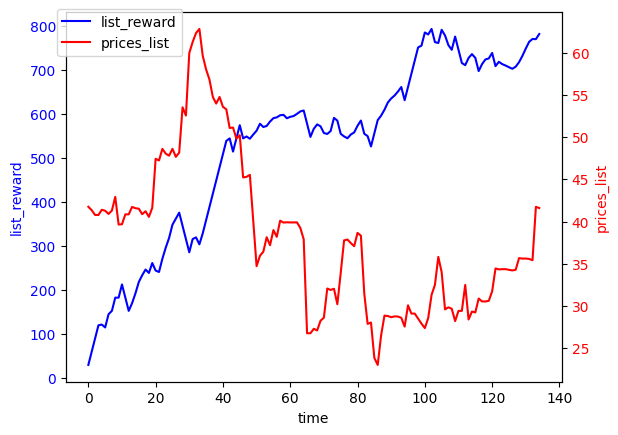

In [175]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()

ax1.plot(list_reward, 'b-', label='list_reward')
ax1.set_xlabel('time')
ax1.set_ylabel('list_reward', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(prices_list, 'r-', label='prices_list')
ax2.set_ylabel('prices_list', color='r')
ax2.tick_params(axis='y', labelcolor='r')


fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# plt.title('Two Lists with Different Scales')
plt.show()

In [ ]:
df = pd.read_csv("./data_his/ORDIUSDT_2024-08-11_2024-09-03_15m.csv")
df.rename(columns={'volumn': 'volume'}, inplace=True)

df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)


In [ ]:
import mplfinance as mpf


mpf.plot(df, type='candle', style='charles', volume=False, title=f"K-Line Chart", ylabel='Price (USDT)', figratio=(15, 8),  figscale=1)

In [177]:
df['rsi_6']

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
13147    40.783208
13148    20.811626
13149     9.460829
13150    20.956983
13151    60.911276
Name: rsi_6, Length: 13152, dtype: float64

In [158]:
rs2

[(105, '2024-06-05 22:30:00', '2024-06-06 00:45:00', 'not', -11.64),
 (243, '2024-06-07 09:00:00', '2024-06-07 10:45:00', 'high'),
 (260, '2024-06-07 13:15:00', '2024-06-07 15:30:00', 'low'),
 (262, '2024-06-07 13:45:00', '2024-06-07 15:00:00', 'low'),
 (263, '2024-06-07 14:00:00', '2024-06-07 15:00:00', 'low'),
 (267, '2024-06-07 15:00:00', '2024-06-07 17:15:00', 'not', 3.85),
 (268, '2024-06-07 15:15:00', '2024-06-07 17:30:00', 'not', -10.72),
 (274, '2024-06-07 16:45:00', '2024-06-07 19:00:00', 'not', -15.85),
 (288, '2024-06-07 20:15:00', '2024-06-07 22:30:00', 'not', 10.62),
 (302, '2024-06-07 23:45:00', '2024-06-08 00:00:00', 'low'),
 (399, '2024-06-09 00:00:00', '2024-06-09 02:15:00', 'not', 26.29),
 (400, '2024-06-09 00:15:00', '2024-06-09 02:30:00', 'not', 25.05),
 (535, '2024-06-10 10:00:00', '2024-06-10 10:45:00', 'low'),
 (536, '2024-06-10 10:15:00', '2024-06-10 10:45:00', 'low'),
 (556, '2024-06-10 15:15:00', '2024-06-10 17:30:00', 'not', -16.18),
 (620, '2024-06-11 07:15:

In [176]:
data = df['close']
rsi_ema = calculate_rsi_with_ema(data, window=6)
df['rsi_6'] =  rsi_ema


In [181]:
data=df.iloc[1000:1030]['close']

In [182]:
rsi_ema = calculate_rsi_with_ema(data, window=6)


In [184]:
df.iloc[1000:1030]['rsi_6']

1000    58.539825
1001    54.149001
1002    70.935208
1003    59.791309
1004    68.461903
1005    83.450538
1006    84.153446
1007    64.867548
1008    84.613853
1009    62.487453
1010    76.098829
1011    58.978589
1012    49.278095
1013    30.824078
1014    28.523414
1015    58.718836
1016    67.066523
1017    67.066523
1018    45.860613
1019    68.071090
1020    82.094573
1021    82.799664
1022    49.832447
1023    52.059365
1024    80.266029
1025    72.478841
1026    79.101922
1027    88.506324
1028    89.299446
1029    93.616374
Name: rsi_6, dtype: float64

In [183]:
rsi_ema

1000          NaN
1001          NaN
1002          NaN
1003          NaN
1004          NaN
1005    89.811977
1006    90.349369
1007    65.985454
1008    86.449008
1009    62.688933
1010    76.659449
1011    58.989369
1012    49.088740
1013    30.472327
1014    28.171231
1015    58.720044
1016    67.112329
1017    67.112329
1018    45.814115
1019    68.091673
1020    82.123071
1021    82.827859
1022    49.826359
1023    52.055036
1024    80.272001
1025    72.482301
1026    79.105797
1027    88.509430
1028    89.302414
1029    93.618393
Name: close, dtype: float64